# **NLP - LABORATORIO CNN**
**Nombre:** Bryan Núñez

## **PREPROCESAMIENTO DE DATOS**

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator # experimentacion con libreria de pytorch
from torchtext.data.utils import get_tokenizer

# Cargar el conjunto de datos
df = pd.read_csv('lab2/train.tsv', sep='\t')

# Etiquetas y texto
texts = df['Phrase'].values
labels = df['Sentiment'].values

# Tokenización del texto
tokenizer = get_tokenizer("basic_english")

# Crear vocabulario basado en los datos de entrenamiento
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(texts), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Convertir las secuencias a índices de palabras
def text_pipeline(x):
    return [vocab[token] for token in tokenizer(x)]

# Crear un dataset personalizado
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(text_pipeline(text), dtype=torch.long) for text in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Crear datasets
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

# Definir el collate_fn para rellenar las secuencias
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True)
    labels = torch.stack(labels)
    return texts_padded, labels

# Cargar los datos en DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)


## **MODELO**

Se diseñó la siguiente red neuronal convolucional (CNN) aplicada para el análisis de texto, diseñada para clasificar oraciones en categorías de sentimiento. Aquí está la explicación breve de cada parte:

Capa de Embedding: Convierte las palabras de una oración en vectores numéricos de dimensión fija (embed_dim), representando su significado de manera densa.

Capas de Convolución: Aplica tres convoluciones 2D con diferentes tamaños de ventana (3, 4 y 5 palabras), lo que permite capturar patrones y relaciones locales entre las palabras. Cada convolución genera 100 mapas de características (filtros).

Max Pooling: Reduce la dimensión de salida de las convoluciones seleccionando los valores más importantes en cada mapa de características, lo que ayuda a extraer las características más relevantes de la oración.

Capa Totalmente Conectada (fc): Toma las características extraídas por las capas convolucionales y las usa para clasificar la oración en una de las clases de salida (num_class), en este caso, categorías de sentimiento.

Dropout: Ayuda a evitar el sobreajuste durante el entrenamiento al apagar aleatoriamente algunas neuronas en cada iteración.

In [31]:
class CNN_Text(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(CNN_Text, self).__init__()
        #Embedding
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Definir las capas de convolución
        self.conv1 = nn.Conv2d(1, 100, kernel_size=(3, embed_dim))  # 100 filtros, ventana de 3 palabras
        self.conv2 = nn.Conv2d(1, 100, kernel_size=(4, embed_dim))  # 100 filtros, ventana de 4 palabras
        self.conv3 = nn.Conv2d(1, 100, kernel_size=(5, embed_dim))  # 100 filtros, ventana de 5 palabras

        # Capa totalmente conectada para la salida
        self.fc = nn.Linear(300, num_class)
        self.dropout = nn.Dropout(0.5)

    def forward(self, text):
        # El embedding devuelve la secuencia de palabras (batch_size, sequence_length, embed_dim)
        embedded = self.embedding(text)
        
        # Agregar dimensión de canal (batch_size, 1, sequence_length, embed_dim)
        embedded = embedded.unsqueeze(1)

        # Aplicar convoluciones, seguido por max pooling
        conv1_out = F.relu(self.conv1(embedded)).squeeze(3)
        conv2_out = F.relu(self.conv2(embedded)).squeeze(3)
        conv3_out = F.relu(self.conv3(embedded)).squeeze(3)

        # Max pooling sobre la secuencia
        conv1_out = F.max_pool1d(conv1_out, conv1_out.size(2)).squeeze(2)
        conv2_out = F.max_pool1d(conv2_out, conv2_out.size(2)).squeeze(2)
        conv3_out = F.max_pool1d(conv3_out, conv3_out.size(2)).squeeze(2)

        # Concatenar las salidas de las convoluciones
        out = torch.cat([conv1_out, conv2_out, conv3_out], 1)
        out = self.dropout(out) #evitar sobreajuste
        
        # Salida final
        return self.fc(out)



## **ENTRENAMIENTO DEL MODELO**

In [54]:
# Parámetros del modelo
vocab_size = len(vocab)
embed_dim = 100
num_class = 5  # 5 clases de sentimiento (0-4)

# Inicializar el modelo
model = CNN_Text(vocab_size, embed_dim, num_class)

# Definir la función de pérdida y el optimizador SGD
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

import matplotlib.pyplot as plt

# Función modificada para entrenar el modelo y almacenar métricas
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=50):
    model.train()
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        # Entrenamiento
        for texts, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Guardar la pérdida de entrenamiento para la época
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluación en el conjunto de validación (test_loader)
        model.eval()
        with torch.no_grad():
            for texts, labels in test_loader:
                outputs = model(texts)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        # Precisión de validación para la época
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        
        model.train()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    return train_losses, val_accuracies

# Llamada a la función de entrenamiento
train_losses, val_accuracies = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=100)




Epoch 1/100, Loss: 1.2459, Val Accuracy: 0.5305
Epoch 2/100, Loss: 1.1567, Val Accuracy: 0.5579
Epoch 3/100, Loss: 1.1080, Val Accuracy: 0.5774
Epoch 4/100, Loss: 1.0790, Val Accuracy: 0.5829
Epoch 5/100, Loss: 1.0516, Val Accuracy: 0.5912
Epoch 6/100, Loss: 1.0330, Val Accuracy: 0.6038
Epoch 7/100, Loss: 1.0173, Val Accuracy: 0.5915
Epoch 8/100, Loss: 1.0055, Val Accuracy: 0.6077
Epoch 9/100, Loss: 0.9931, Val Accuracy: 0.6074
Epoch 10/100, Loss: 0.9790, Val Accuracy: 0.6080
Epoch 11/100, Loss: 0.9701, Val Accuracy: 0.6173
Epoch 12/100, Loss: 0.9564, Val Accuracy: 0.6113
Epoch 13/100, Loss: 0.9550, Val Accuracy: 0.6175
Epoch 14/100, Loss: 0.9408, Val Accuracy: 0.6099
Epoch 15/100, Loss: 0.9385, Val Accuracy: 0.6234
Epoch 16/100, Loss: 0.9302, Val Accuracy: 0.6227
Epoch 17/100, Loss: 0.9218, Val Accuracy: 0.6163
Epoch 18/100, Loss: 0.9183, Val Accuracy: 0.6225
Epoch 19/100, Loss: 0.9114, Val Accuracy: 0.6246
Epoch 20/100, Loss: 0.9043, Val Accuracy: 0.6301
Epoch 21/100, Loss: 0.8993, V

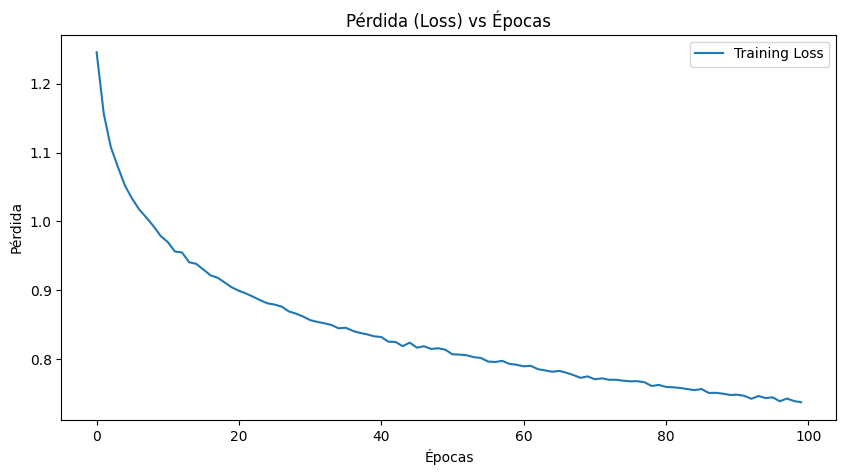

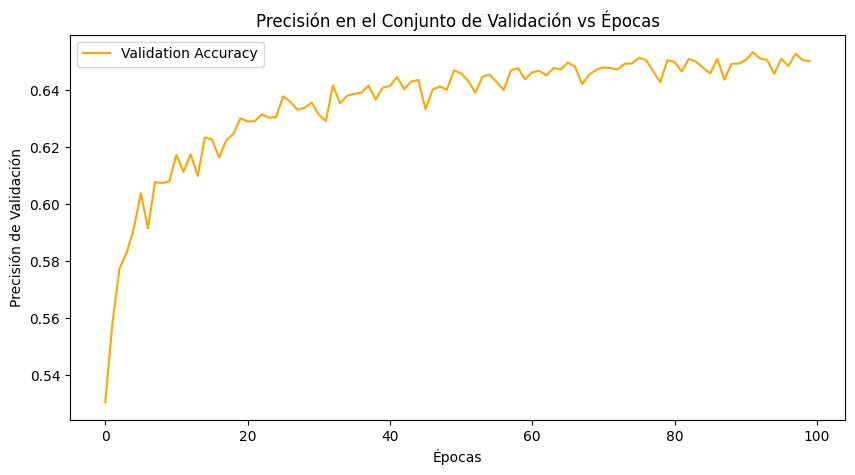

In [55]:
# Graficar las pérdidas y la precisión de validación
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Pérdida (Loss) vs Épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Precisión en el Conjunto de Validación vs Épocas')
plt.xlabel('Épocas')
plt.ylabel('Precisión de Validación')
plt.legend()
plt.show()

**Gráfico de Pérdida (Loss) vs Épocas:**

La pérdida disminuye de manera consistente a lo largo de las épocas, lo que indica que el modelo está aprendiendo progresivamente.
Alrededor de la época 40, el descenso de la pérdida se vuelve más suave, lo que podría indicar que el modelo está alcanzando un punto de estabilidad y está ajustándose bien a los datos.

La precisión en el conjunto de validación muestra una tendencia creciente al inicio, lo que es positivo.
Sin embargo, a partir de la época 40, la precisión oscila alrededor del 63-65%. Esto puede indicar que el modelo ha alcanzado su mejor capacidad predictiva y no mejora significativamente a medida que avanza el entrenamiento.

## **RESULTADOS**

Accuracy Total: 0.6502
F1-Score: 0.6293
Precision: 0.6351
Recall: 0.6502


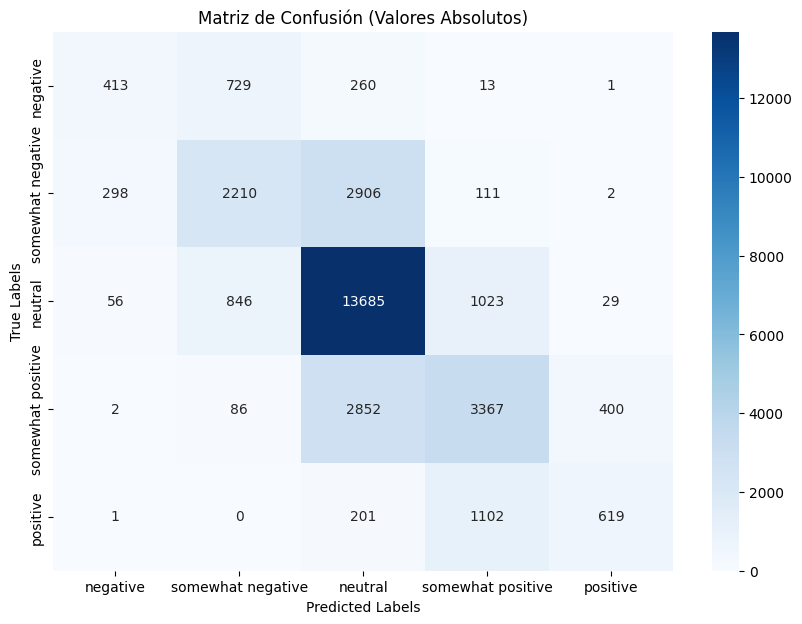

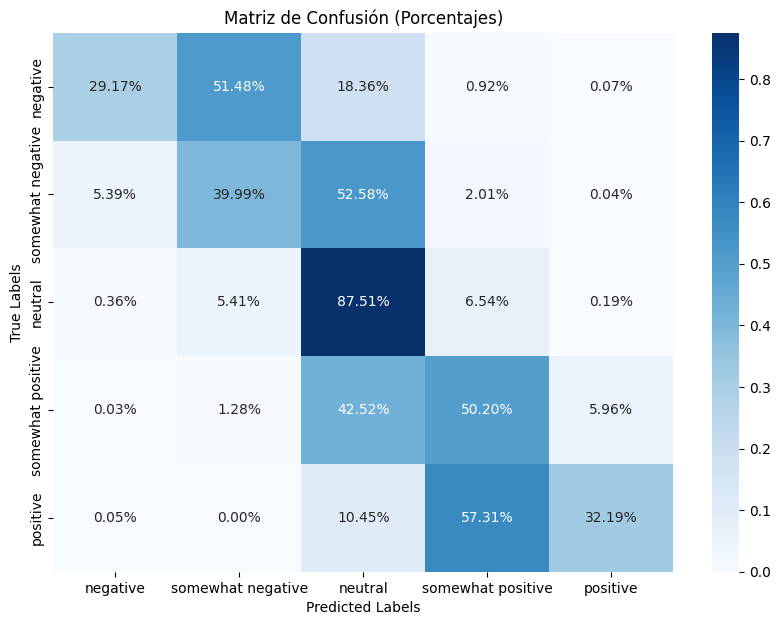

In [59]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
class_names = {
    0: 'negative',
    1: 'somewhat negative',
    2: 'neutral',
    3: 'somewhat positive',
    4: 'positive'
}



# Función para calcular y mostrar las métricas de evaluación
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for texts, labels in test_loader:
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
            y_scores.extend(outputs.cpu().numpy())

    # Cálculo de métricas
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    # Matriz de Confusión
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Matriz de Confusión en Porcentajes
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Mostrar resultados
    print(f'Accuracy Total: {accuracy:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

    # Visualizar la matriz de confusión (valores absolutos)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[class_names[i] for i in np.unique(y_true)], 
                yticklabels=[class_names[i] for i in np.unique(y_true)])
    plt.title('Matriz de Confusión (Valores Absolutos)')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Visualizar la matriz de confusión (porcentajes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=[class_names[i] for i in np.unique(y_true)], 
                yticklabels=[class_names[i] for i in np.unique(y_true)])
    plt.title('Matriz de Confusión (Porcentajes)')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return y_true, y_scores

# Evaluar el modelo y calcular métricas
y_true, y_scores = evaluate_model(model, test_loader)


**Matriz de Confusión (Valores Absolutos y Porcentajes):**

El modelo tiene un rendimiento notable al clasificar la clase "neutral" con una precisión del 87.5%. Sin embargo, hay confusión significativa entre las clases cercanas, como "somewhat negative" y "neutral", lo que se refleja en la dispersión de predicciones entre estas categorías.
La clase "positive" es la menos frecuente y la más difícil de predecir, con un 32.19% de precisión.

Los porcentajes muestran que las clases intermedias (somewhat negative, somewhat positive) son las más difíciles de separar, lo que indica que el modelo tiene problemas para diferenciar sentimientos ligeramente diferentes.

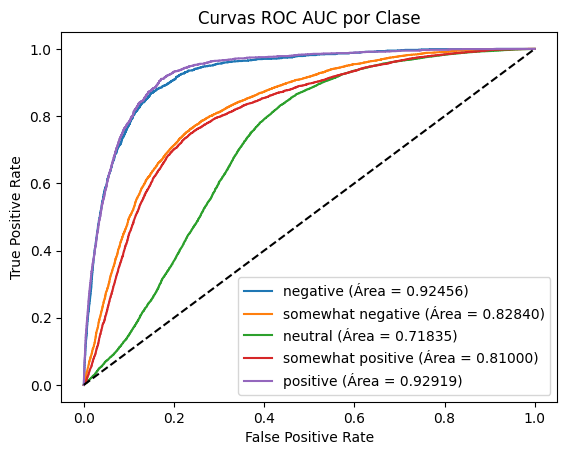

In [61]:
# Cálculo y visualización de las curvas ROC AUC
def plot_roc_auc(y_true, y_scores, num_classes=5):
    # Binarizar las etiquetas
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
    
    # ROC AUC para cada clase
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], np.array(y_scores)[:, i])
        roc_auc = roc_auc_score(y_true_bin[:, i], np.array(y_scores)[:, i])
        # Mostrar la etiqueta de la clase en lugar del número
        plt.plot(fpr, tpr, label=f'{class_names[i]} (Área = {roc_auc:.5f})')

    # Línea diagonal para referencia
    plt.plot([0, 1], [0, 1], 'k--')

    # Configurar los títulos y etiquetas del gráfico
    plt.title('Curvas ROC AUC por Clase')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

# Llamar a la función para generar las curvas ROC AUC
plot_roc_auc(y_true, y_scores)

**Curvas ROC AUC:**

La clase "neutral" tiene el área bajo la curva más baja (0.718), lo que sugiere que el modelo tiene dificultades para distinguir correctamente entre neutral y otras clases.

Por otro lado, las clases "negative" y "positive" tienen las áreas más altas (0.924 y 0.929 respectivamente), lo que indica que el modelo es mejor clasificando las opiniones más extremas.

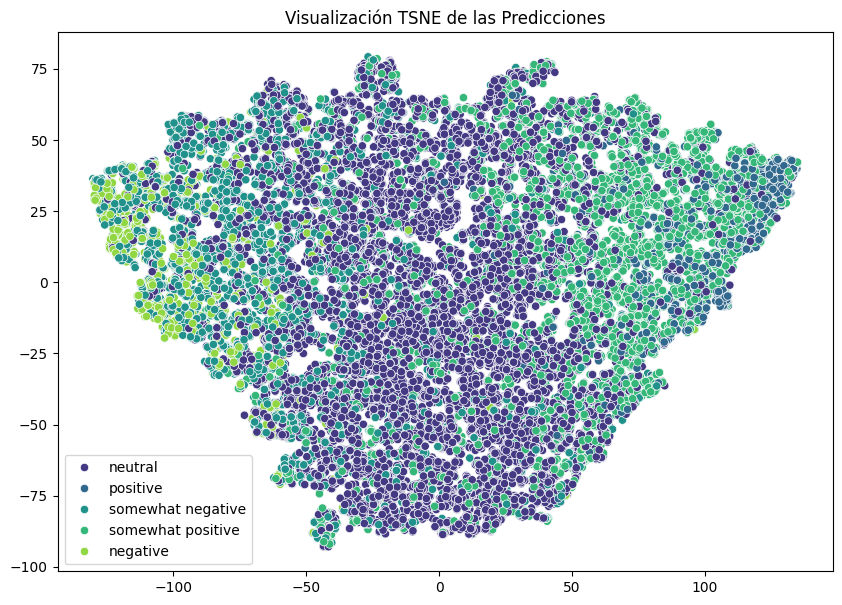

In [58]:
from sklearn.manifold import TSNE
import numpy as np

# Nombres de las clases para mapear los números a etiquetas
class_names = {
    0: 'negative',
    1: 'somewhat negative',
    2: 'neutral',
    3: 'somewhat positive',
    4: 'positive'
}

# Visualización con TSNE con etiquetas en lugar de números
def plot_tsne(y_scores, y_true):
    # Convertir y_scores a un array de NumPy si es una lista
    y_scores = np.array(y_scores)

    # Convertir las etiquetas numéricas a nombres de clases
    y_true_labels = [class_names[label] for label in y_true]
    
    # Aplicar TSNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(y_scores)

    # Visualizar los resultados de TSNE
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=y_true_labels, palette="viridis", legend="full")
    plt.title('Visualización TSNE de las Predicciones')
    plt.show()

# Generar gráfico TSNE
plot_tsne(y_scores, y_true)


**Gráfico TSNE:**

La visualización TSNE muestra una gran densidad de puntos para la clase "neutral", lo que es consistente con la matriz de confusión. Esto puede deberse a que muchas reseñas caen en una zona intermedia y el modelo no está separando bien las otras clases.

Las clases "positive" y "negative" están más dispersas, lo que también coincide con su mejor rendimiento en las curvas ROC AUC.

## **Conclusiones**

- Conclusión 1: El modelo muestra un buen rendimiento en las clases "negative" y "positive", lo que indica que es efectivo al clasificar sentimientos extremos. Sin embargo, tiene dificultades al distinguir entre las clases intermedias como "somewhat negative" y "neutral".

- Conclusión 2: A pesar de la estabilidad en la pérdida y precisión después de la época 40, el modelo podría beneficiarse de más ajustes, como la implementación de técnicas avanzadas de preprocesamiento o un modelo más complejo, para mejorar la precisión en las clases intermedias.

- El modelo presenta un rendimiento aceptable con una precisión y recall del 65%, lo que indica que predice correctamente dos de cada tres casos. El F1-Score de 0.6293 refleja un balance razonable entre precisión y recall, aunque podría mejorar. La precisión del 63.5% sugiere que el modelo es confiable, pero puede tener dificultades para distinguir entre clases más cercanas. Estas metricas superaron al anteriormente probado en el laboratorio 2, y se tiene una tendencia a mejorar posiblemnete realizando algunos cambios en la aruitectura del modelo o entrenando mas epocas.

#### Referencias:
- https://pytorch.org/text/stable/vocab.html#build-vocab-from-iterator
- https://pytorch.org/text/stable/data_utils.html#get-tokenizer